## SHAP

- 모델은 왜 그렇게 예측하였을까?

### 1. 환경준비

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 16.0 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
tf.compat.v1.disable_v2_behavior()

import shap

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# data load
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [4]:
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

### 2. 데이터 준비

In [5]:
# x, y split
target = 'medv'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 10)

In [6]:
# scaling (DL모델과 SVM모델에 사용)
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 3. 모델링 및 해석

In [7]:
# RandomForest
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

RandomForestRegressor()

In [8]:
# Shapley Value 만들기

# SHAP 값으로 모델의 예측 설명하기
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x_train)

In [9]:
x_train.shape, shap_values1.shape

((404, 13), (404, 13))

In [10]:
x_train[:2]

crim    zn  indus  chas    nox     rm    age     dis  rad  tax  \
50    0.08873  21.0   5.64     0  0.439  5.963   45.7  6.8147    4  243   
367  13.52220   0.0  18.10     0  0.631  3.863  100.0  1.5106   24  666   

     ptratio   black  lstat  
50      16.8  395.56  13.45  
367     20.2  131.42  13.33

In [11]:
pd.DataFrame(shap_values1, columns = list(x))[:2]

crim        zn     indus      chas       nox        rm       age  \
0  0.268095  0.003841 -0.101530 -0.009729  0.298936 -2.235247  0.139437   
1  0.080462 -0.000707  0.074853  0.006451  0.182755 -1.557302 -0.129018   

        dis       rad       tax   ptratio     black     lstat  
0 -0.484089 -0.018237  0.293962  0.276333  0.124079 -0.495084  
1  0.466035  0.051285 -0.126126 -0.077750 -0.098929  0.171758

In [12]:
# 특정 데이터에 대한 설명
x_train.iloc[0:1,:]

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
50  0.08873  21.0   5.64     0  0.439  5.963  45.7  6.8147    4  243     16.8   

     black  lstat  
50  395.56  13.45

In [13]:
# 예측값

# 예측하기 위해서는 입력데이터(x)가 2차원
pred = model1.predict(x_train.iloc[0:1,:])
pred, pred[0]

(array([19.895]), 19.895000000000024)

In [14]:
# train의 예측값 전체 평균
## 보통, 실제값의 평균(y_train.mean())과 예측값의 평균(pred.mean())은 거의 같다.
model1.predict(x_train).mean()

21.84006435643564

In [15]:
# 예측값과 y평균간 차
pred[0] - model1.predict(x_train).mean()

-1.9450643564356156

In [17]:
# Shapley Value
## 소수점 반올림값 때문에 약간 차이가 있음.
pd.DataFrame(shap_values1[0:1, :], columns = list(x_train))

crim        zn    indus      chas       nox        rm       age  \
0  0.268095  0.003841 -0.10153 -0.009729  0.298936 -2.235247  0.139437   

        dis       rad       tax   ptratio     black     lstat  
0 -0.484089 -0.018237  0.293962  0.276333  0.124079 -0.495084

In [18]:
shap_values1[0:1, :].sum()

-1.9392326732673142

In [19]:
# 시각화
explainer1.expected_value

array([21.83423267])

In [20]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[0, :], x_train.iloc[0,:])

### 4. 실습

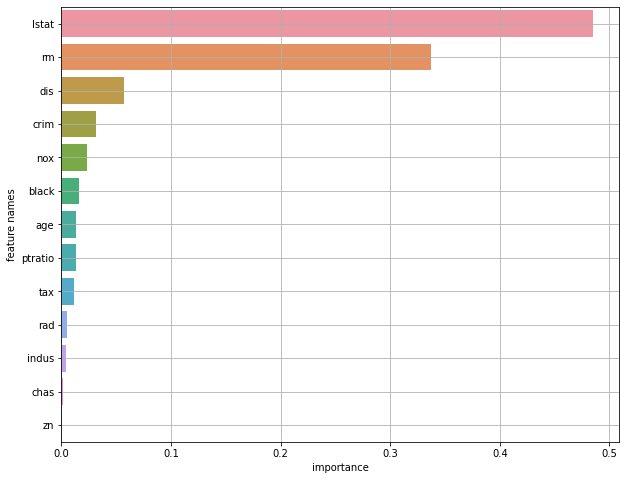

In [21]:
# 1. 모델의 변수 중요도
result = plot_feature_importance(model1.feature_importances_, list(x_train))

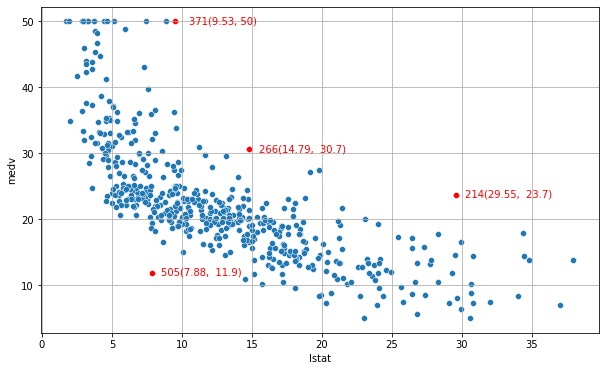

In [22]:
# 2. 전체 흐름에서 벗어나 보이는 값들 분석
plt.figure(figsize = (10,6))
sns.scatterplot(x='lstat', y = 'medv', data = data)

sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[371]], color = 'r')
plt.text(10.5, 49.6, '371(9.53, 50)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[266]], color = 'r')
plt.text(15.5, 30.2, '266(14.79,  30.7)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[505]], color = 'r')
plt.text(8.5, 11.5, '505(7.88,  11.9)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[214]], color = 'r')
plt.text(30.2, 23.3, '214(29.55,  23.7)', color = 'r')

plt.grid()
plt.show()

In [23]:
# SHAP 값으로 모델의 예측 설명하기
shap_values1 = explainer1.shap_values(x)

In [24]:
# index=371
data.iloc[[371]]

crim   zn  indus  chas    nox     rm    age     dis  rad  tax  ptratio  \
371  9.2323  0.0   18.1     0  0.631  6.216  100.0  1.1691   24  666     20.2   

      black  lstat  medv  
371  366.15   9.53  50.0

In [25]:
shap_values1[371:372, :]

array([[ 2.06516173e-01, -9.08730046e-04,  3.80882943e-02,
        -6.09340911e-03,  3.83074943e-02, -3.37237618e-01,
        -1.55558589e-01,  1.20480562e+01,  5.81744494e-03,
        -1.73527903e-01, -1.16639623e-01,  2.11901746e-01,
         5.84704582e+00]])

In [26]:
shap.initjs()
index = 371
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index,:])

- lstat = 9.53 ==> 실제 값
- 화살표의 길이 ==> shapley value, 기여도

In [27]:
# index=256
shap.initjs() 
index = 266
display(x.iloc[index,:])
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index,:])

crim         0.7857
zn          20.0000
indus        3.9700
chas         0.0000
nox          0.6470
rm           7.0140
age         84.6000
dis          2.1329
rad          5.0000
tax        264.0000
ptratio     13.0000
black      384.0700
lstat       14.7900
Name: 266, dtype: float64

In [28]:
# index=505
shap.initjs() 
index = 505
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index,:])

In [29]:
# index=214
shap.initjs() 
index = 214
shap.force_plot(explainer1.expected_value, shap_values1[index, :], x.iloc[index,:])

### 5. 추가 분석

#### 1) 데이터 전체를 한눈에 보기

In [30]:
# 1. 전체 변수에 대한 shap value 시각화
shap_values1 = explainer1.shap_values(x_train)

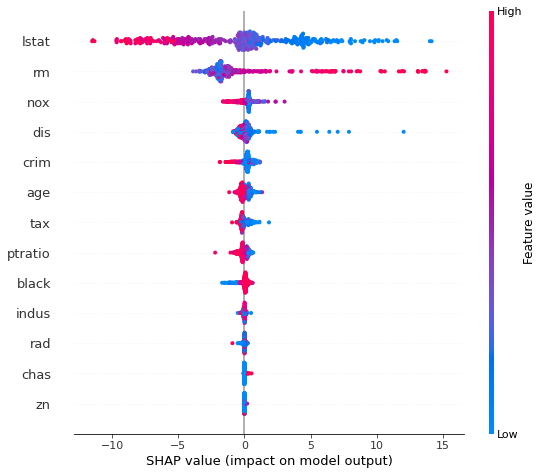

In [31]:
shap.summary_plot(shap_values1, x_train)

In [32]:
# 2. 특정 관점으로 Data Point의 Shape Value 정렬
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, x_train)

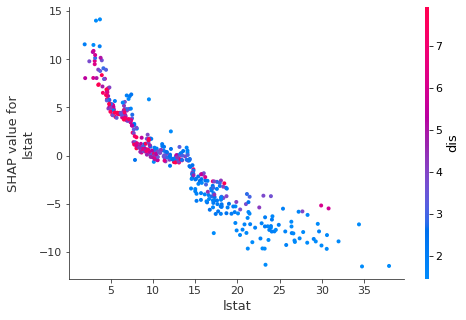

In [33]:
# 3. 특정 변수 값과 변수의 shap value간의 관계
shap.dependence_plot('lstat', shap_values1, x_train)

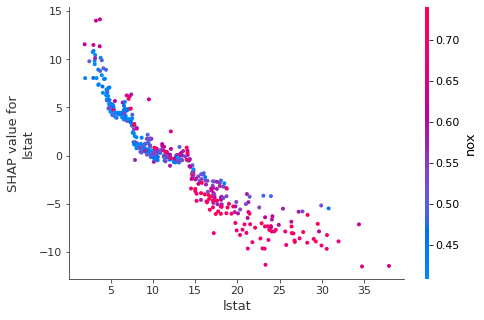

In [34]:
shap.dependence_plot('lstat', shap_values1, x_train, interaction_index = 'nox')

#### 2) Kernel Explainer

In [35]:
# SVM모델링 -> SVM에 대한 shapley value 계산은 오래 걸리기 때문에 줄여서 수행.
model2 = SVR()
model2.fit(x_train_s, y_train)

SVR()

In [36]:
# Shape Value 만들기
explainer2 = shap.KernelExplainer(model2.predict, x_train_s)

# 10건만 수행
shap_values2 = explainer2.shap_values(x_train_s[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
shap_values2

array([[ 8.61590960e-02,  2.09003002e-01,  3.48189404e-01,
        -8.24934592e-02,  3.27727799e-01, -6.76601367e-01,
         8.02135102e-01, -1.04739805e+00, -2.17634782e-01,
         8.17636429e-01,  8.48011987e-01,  2.36790637e-01,
        -1.47450038e-01],
       [-2.64243834e-01, -2.16675325e-01, -3.71505527e-01,
        -1.58961851e-01, -2.94130619e-01, -2.11949752e+00,
        -9.05771339e-01,  3.57746494e-01,  3.37830157e-01,
        -9.30570081e-01, -5.83417963e-01, -1.36601743e+00,
        -5.74384014e-02],
       [ 6.19104572e-02, -2.94524169e-01,  6.32573838e-02,
        -1.60800504e-01,  1.61950922e-01, -3.60507225e-01,
        -8.99840603e-01,  1.26106847e-01, -1.13168170e-01,
         4.69893679e-01, -1.27007262e+00, -7.22101041e-01,
        -2.06604101e+00],
       [ 1.07101368e-01, -2.92169204e-01, -2.01466211e-01,
        -1.03160136e-01,  4.39880309e-01, -9.60817585e-02,
         6.42334293e-01, -2.73150900e-01, -2.06277371e-01,
        -3.59995805e-02, -1.73156215e

In [38]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2, x_train_s[:10])

In [39]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0], x_train.iloc[0])

#### 3) DeepExplainer

In [49]:
# 1. Deep Learning 모델링
nfeatures = x_train.shape[1]

clear_session()

model3 = Sequential([Dense(4, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(1)])

model3.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

history = model3.fit(x_train_s, y_train, 
                     epochs = 100, batch_size = 64,
                     validation_split=0.2).history

Train on 323 samples, validate on 81 samples
Epoch 1/100
323/323 [==============================] - 0s 738us/sample - loss: 497.1047 - val_loss: 406.6134
Epoch 2/100
323/323 [==============================] - 0s 71us/sample - loss: 305.3083 - val_loss: 159.9461
Epoch 3/100
323/323 [==============================] - 0s 112us/sample - loss: 146.6692 - val_loss: 136.2782
Epoch 4/100
323/323 [==============================] - 0s 92us/sample - loss: 156.2876 - val_loss: 88.9702
Epoch 5/100
323/323 [==============================] - 0s 107us/sample - loss: 97.4957 - val_loss: 81.1123
Epoch 6/100
323/323 [==============================] - 0s 80us/sample - loss: 85.1570 - val_loss: 66.3789
Epoch 7/100
323/323 [==============================] - 0s 62us/sample - loss: 63.8401 - val_loss: 52.5065
Epoch 8/100
323/323 [==============================] - 0s 64us/sample - loss: 51.9836 - val_loss: 51.9727
Epoch 9/100
323/323 [==============================] - 0s 63us/sample - loss: 47.2004 - val_loss:

In [50]:
# 2. Shape Value 만들기
## DeepExplainer로부터 shap_values를 추출하면,
### 리스트 안에 np.array로 값이 저장.
### 이를 사용하려면 값을 뽑아내서 리스트[0]로 사용해야 한다.
explainer = shap.DeepExplainer(model3, x_train_s)
shap_values = explainer.shap_values(x_train_s)

In [51]:
shap_values

[array([[ 0.48243806,  0.16716594, -0.87345477, ...,  0.12375358,
          0.61993872, -0.84909129],
        [-1.25418965, -0.13736975,  0.93874499, ..., -0.41129046,
         -3.35132273, -0.3486795 ],
        [ 0.28200332, -0.12231593, -0.51086801, ..., -0.69101685,
         -1.62916551, -4.13038928],
        ...,
        [ 0.18204551, -0.12394773,  0.92620663, ..., -0.51743999,
          0.23873118, -0.46544567],
        [ 0.47151048, -0.08793866,  1.96288985, ..., -0.49435422,
          0.4532061 , -1.58047858],
        [ 0.40473765,  0.13706001, -1.04367376, ...,  3.15123218,
          0.61957631,  0.6375289 ]])]

In [52]:
# 리스트에서 값을 빼내기
shap_values = shap_values[0]

In [53]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])

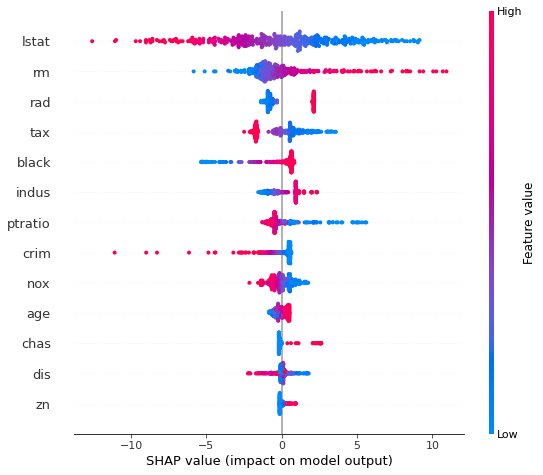

In [55]:
shap.summary_plot(shap_values, x_train)

### 6. 정리

- shap.TreeExplainer(모델)
- shap.KernelExplainer(모델.predict, x)
- shap.DeepExplainer(모델, x_train_s)
- knn : shap.KernelExplainer(모델.predict_proba, x)